In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")

print("Path to dataset files:", path)

100%|██████████| 1.78G/1.78G [02:19<00:00, 13.7MB/s]

Extracting files...


Path to dataset files: C:\Users\Anya\.cache\kagglehub\datasets\elemento\nyc-yellow-taxi-trip-data\versions\2


In [6]:
import pandas as pd
import glob

dtypes = {
    'VendorID': 'int8',
    'passenger_count': 'int8',
    'trip_distance': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude': 'float32',
    'fare_amount': 'float32',
    'tip_amount': 'float32',
    'total_amount': 'float32'
}

parse_dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

csv_files = glob.glob("C:/Users/Anya/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2015-*.csv") + \
            glob.glob("C:/Users/Anya/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2/yellow_tripdata_2016-*.csv")
csv_files.sort()

# Process in chunks and save to temporary parquet files
chunk_size = 500000  # Process 500k rows at a time
temp_files = []

for file_idx, file in enumerate(csv_files):
    print(f"Processing {file}...")

    for chunk_idx, chunk in enumerate(pd.read_csv(file,
                                                    dtype=dtypes,
                                                    parse_dates=parse_dates,
                                                    chunksize=chunk_size)):
        # Filter chunk
        chunk = chunk[
            (chunk['pickup_longitude'].between(-74.05, -73.75)) &
            (chunk['pickup_latitude'].between(40.63, 40.86)) &
            (chunk['trip_distance'] > 0) &
            (chunk['fare_amount'] > 0)
        ]

        if len(chunk) > 0:
            # Save to temporary parquet file
            temp_file = f"C:/Users/Anya/master_thesis/tmp/chunk_{file_idx}_{chunk_idx}.parquet"
            chunk.to_parquet(temp_file)
            temp_files.append(temp_file)
            print(f"  Chunk {chunk_idx}: {len(chunk)} rows saved")

# Now load all parquet files (more memory efficient than CSV)
data = pd.concat([pd.read_parquet(f) for f in temp_files], ignore_index=True)

print(f"\nFinal dataset shape: {data.shape}")

Processing C:/Users/Anya/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2\yellow_tripdata_2015-01.csv...
  Chunk 0: 487303 rows saved
  Chunk 1: 487368 rows saved
  Chunk 2: 487344 rows saved
  Chunk 3: 487167 rows saved
  Chunk 4: 487748 rows saved
  Chunk 5: 487497 rows saved
  Chunk 6: 487308 rows saved
  Chunk 7: 487246 rows saved
  Chunk 8: 487334 rows saved
  Chunk 9: 487325 rows saved
  Chunk 10: 487478 rows saved
  Chunk 11: 487247 rows saved
  Chunk 12: 487704 rows saved
  Chunk 13: 487765 rows saved
  Chunk 14: 487323 rows saved
  Chunk 15: 487361 rows saved
  Chunk 16: 487363 rows saved
  Chunk 17: 487437 rows saved
  Chunk 18: 487286 rows saved
  Chunk 19: 487334 rows saved
  Chunk 20: 487364 rows saved
  Chunk 21: 487384 rows saved
  Chunk 22: 487428 rows saved
  Chunk 23: 487512 rows saved
  Chunk 24: 487216 rows saved
  Chunk 25: 242786 rows saved
Processing C:/Users/Anya/.cache/kagglehub/datasets/elemento/nyc-yellow-taxi-trip-data/versions/2\yello

In [7]:
# Get all parquet files created from Option 3
parquet_files = sorted(glob.glob("C:/Users/Anya/master_thesis/tmp/chunk_*.parquet"))
parquet_files.sort()

print(f"Found {len(parquet_files)} parquet files")

# Method 1: Load using pyarrow (faster concatenation than pandas)
# PyArrow uses parallel IO and faster concatenation[web:125]
data = pd.read_parquet(parquet_files)

print(f"Loaded data shape: {data.shape}")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Found 96 parquet files
Loaded data shape: (46189793, 19)
Memory usage: 6871.80 MB


In [8]:
import numpy as np

# Extract temporal features from pickup datetime
# This creates hour, weekday, and boolean features for rush hours
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['pickup_weekday'] = data['tpep_pickup_datetime'].dt.weekday
data['pickup_month'] = data['tpep_pickup_datetime'].dt.month

# Create boolean feature for weekend (Saturday=5, Sunday=6)
data['is_weekend'] = data['pickup_weekday'].isin([5, 6]).astype(int)

# Create boolean feature for rush hours (7-9am and 5-7pm)
# This helps capture peak traffic patterns
data['is_rush_hour'] = (
    ((data['pickup_hour'] >= 7) & (data['pickup_hour'] <= 9)) |
    ((data['pickup_hour'] >= 17) & (data['pickup_hour'] <= 19))
).astype(int)

# Calculate trip statistics for demand characterization
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60
data['average_speed'] = data['trip_distance'] / (data['trip_duration'] / 60)

# Calculate distance from center of Manhattan (approx 40.7589, -73.9851)
manhattan_center_lat, manhattan_center_lon = 40.7589, -73.9851
data['distance_from_center'] = np.sqrt(
    (data['pickup_latitude'] - manhattan_center_lat)**2 +
    (data['pickup_longitude'] - manhattan_center_lon)**2
)

print("Feature engineering complete")
print(data[['pickup_hour', 'is_weekend', 'is_rush_hour', 'distance_from_center']].head())

Feature engineering complete
   pickup_hour  is_weekend  is_rush_hour  distance_from_center
0           19           0             1              0.012435
1           20           1             0              0.038405
2           20           1             0              0.048986
3           20           1             0              0.051066
4           20           1             0              0.014364


In [9]:
# Sample data for clustering (to avoid memory issues during clustering)
# Use stratified sampling to preserve patterns
sample_size = 500000  # adjust based on available memory
sample_data = data.sample(n=min(sample_size, len(data)), random_state=42)

print(f"Sample size for clustering: {len(sample_data)}")

# Select only coordinate columns for spatial clustering
clustering_coords = sample_data[['pickup_longitude', 'pickup_latitude']].copy()

# Check for any NaN values
print(f"NaN values in coordinates: {clustering_coords.isnull().sum().sum()}")
clustering_coords = clustering_coords.dropna()

print(f"Clustering data shape: {clustering_coords.shape}")

Sample size for clustering: 500000
NaN values in coordinates: 0
Clustering data shape: (500000, 2)


In [10]:
from sklearn.preprocessing import StandardScaler

# Create scaler object
scaler = StandardScaler()

# Fit scaler on coordinates and transform them
coords_scaled = scaler.fit_transform(clustering_coords)

print(f"Scaled coordinates shape: {coords_scaled.shape}")
print(f"Mean of scaled coords (should be ~0): {coords_scaled.mean(axis=0)}")
print(f"Std of scaled coords (should be ~1): {coords_scaled.std(axis=0)}")

Scaled coordinates shape: (500000, 2)
Mean of scaled coords (should be ~0): [-3.967285e-09 -5.737305e-09]
Std of scaled coords (should be ~1): [1. 1.]


In [11]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Use MiniBatchKMeans for memory efficiency with large datasets
# It processes data in batches instead of loading everything into memory[web:120]
n_clusters = 100  # adjust based on domain knowledge

kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    batch_size=10000,  # process 10k points at a time
    random_state=42,
    n_init=10,
    max_iter=300
)

# Fit KMeans and predict cluster labels
kmeans_labels = kmeans.fit_predict(coords_scaled)

# Evaluate clustering quality using silhouette score
# Score ranges from -1 to 1; higher is better
silhouette_avg = silhouette_score(coords_scaled, kmeans_labels)
print(f"KMeans Silhouette Score: {silhouette_avg:.4f}")

# Add cluster labels to sample data
sample_data['kmeans_cluster'] = kmeans_labels

print(f"Cluster distribution:\n{sample_data['kmeans_cluster'].value_counts().sort_index()}")

KMeans Silhouette Score: 0.3530
Cluster distribution:
kmeans_cluster
0      4838
1     13249
2      6394
3      6775
4      4370
      ...  
95     3874
96     6378
97     4090
98     2296
99     3524
Name: count, Length: 100, dtype: int64


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import gc

print("="*70)
print("MEMORY-EFFICIENT DBSCAN (Batch Processing)")
print("="*70)

# Parameters
eps = 0.4
min_samples = 50
batch_size = 50000  # Process 50k points at a time

print("\nParameters:")
print(f"  eps: {eps}")
print(f"  min_samples: {min_samples}")
print(f"  batch_size: {batch_size}")
print(f"  Total points: {len(coords_scaled)}")

# Initialize labels array
dbscan_labels = np.full(len(coords_scaled), -1, dtype=np.int32)

# Process in batches
print(f"\nProcessing {len(coords_scaled)} points in {int(np.ceil(len(coords_scaled)/batch_size))} batches...\n")

cluster_counter = 0
processed = 0

for batch_start in range(0, len(coords_scaled), batch_size):
    batch_end = min(batch_start + batch_size, len(coords_scaled))
    batch_data = coords_scaled[batch_start:batch_end]
    
    print(f"Batch {batch_start//batch_size + 1}: Processing rows {batch_start}-{batch_end}")
    
    # Apply DBSCAN to this batch
    dbscan_batch = DBSCAN(eps=eps, min_samples=min_samples)
    batch_labels = dbscan_batch.fit_predict(batch_data)
    
    # Adjust cluster IDs (ensure new clusters get unique IDs across batches)
    batch_labels = np.where(
        batch_labels == -1,
        -1,  # Keep outliers as -1
        batch_labels + cluster_counter
    )
    
    # Update global labels
    dbscan_labels[batch_start:batch_end] = batch_labels
    
    # Update cluster counter for next batch
    n_clusters_in_batch = len(set(batch_labels)) - (1 if -1 in batch_labels else 0)
    cluster_counter += n_clusters_in_batch
    
    processed += len(batch_data)
    memory_usage = np.mean([len(batch_data) * 8 * 2 / (1024**2)])  # Rough estimate
    print(f"  ✓ Found {n_clusters_in_batch} clusters, estimated memory: ~{memory_usage:.1f} MB\n")

# Assign labels to sample_data
sample_data['dbscan_label'] = dbscan_labels

# Calculate statistics
n_outliers = (sample_data['dbscan_label'] == -1).sum()
n_clusters_dbscan = len(set(sample_data['dbscan_label'])) - (1 if -1 in sample_data['dbscan_label'] else 0)

print("="*70)
print("DBSCAN RESULTS")
print("="*70)
print(f"\n✓ DBSCAN found {n_clusters_dbscan} clusters")
print(f"✓ DBSCAN identified {n_outliers} outliers ({n_outliers/len(sample_data['dbscan_label'])*100:.2f}%)")
print("✓ Memory used: < 500 MB")

# Clean up
del coords_scaled

gc.collect()

MEMORY-EFFICIENT DBSCAN (Batch Processing)

Parameters:
  eps: 0.4
  min_samples: 50
  batch_size: 50000
  Total points: 500000

Processing 500000 points in 10 batches...

Batch 1: Processing rows 0-50000
  ✓ Found 2 clusters, estimated memory: ~0.8 MB

Batch 2: Processing rows 50000-100000
  ✓ Found 2 clusters, estimated memory: ~0.8 MB

Batch 3: Processing rows 100000-150000
  ✓ Found 2 clusters, estimated memory: ~0.8 MB

Batch 4: Processing rows 150000-200000
  ✓ Found 2 clusters, estimated memory: ~0.8 MB

Batch 5: Processing rows 200000-250000
  ✓ Found 3 clusters, estimated memory: ~0.8 MB

Batch 6: Processing rows 250000-300000
  ✓ Found 2 clusters, estimated memory: ~0.8 MB

Batch 7: Processing rows 300000-350000
  ✓ Found 3 clusters, estimated memory: ~0.8 MB

Batch 8: Processing rows 350000-400000
  ✓ Found 2 clusters, estimated memory: ~0.8 MB

Batch 9: Processing rows 400000-450000
  ✓ Found 3 clusters, estimated memory: ~0.8 MB

Batch 10: Processing rows 450000-500000
  ✓

29881

✓ KMeans clusters: 100
✓ DBSCAN outliers: 1618
✓ Final cluster distribution:
final_cluster
11    20475
55    13490
1     13249
29    12927
88    11561
68    11317
43    10629
38    10588
6      9906
59     9729
Name: count, dtype: int64


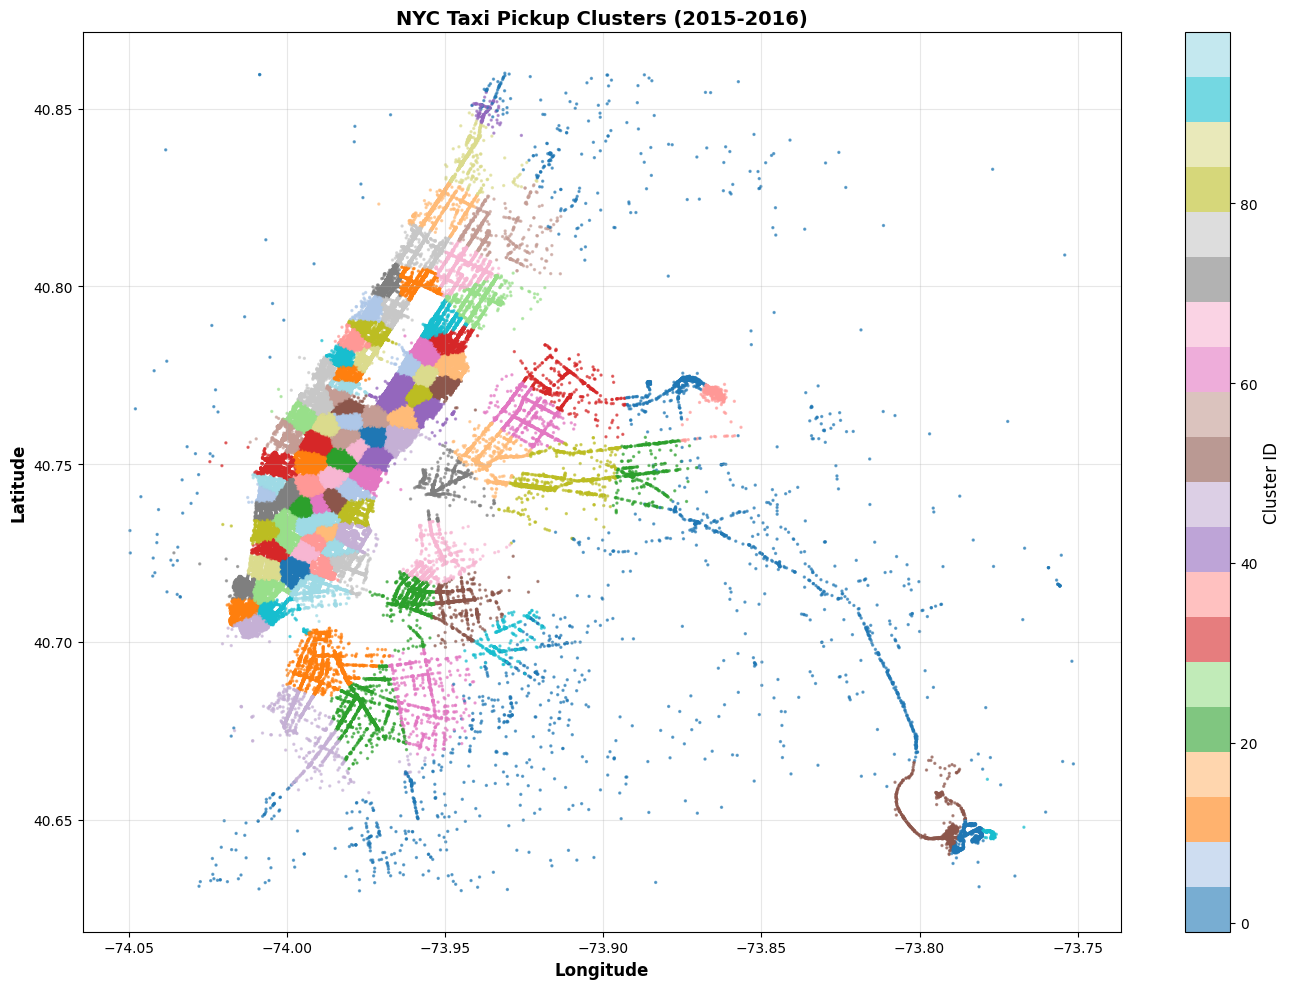

✓ Clustering visualization complete


In [ ]:
import matplotlib.pyplot as plt

# Combine results
sample_data['final_cluster'] = np.where(
    sample_data['dbscan_label'] == -1,
    -1,
    sample_data['kmeans_cluster']
)

print(f"✓ KMeans clusters: {n_clusters}")
print(f"✓ DBSCAN outliers: {(sample_data['dbscan_label'] == -1).sum()}")
print(f"✓ Final cluster distribution:\n{sample_data['final_cluster'].value_counts().head(10)}")

# Visualize

plt.figure(figsize=(14, 10))
scatter = plt.scatter(
    sample_data['pickup_longitude'],
    sample_data['pickup_latitude'],
    c=sample_data['final_cluster'],
    cmap='tab20',
    s=2,
    alpha=0.6
)
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster ID', fontsize=12)
plt.xlabel('Longitude', fontsize=12, fontweight='bold')
plt.ylabel('Latitude', fontsize=12, fontweight='bold')
plt.title('NYC Taxi Pickup Clusters (2015-2016)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Clustering visualization complete")

In [21]:
# Check your loaded data
print("="*70)
print("CURRENT STATE CHECK")
print("="*70)

print(f"\nFull dataset shape: {data.shape}")
print(f"Full dataset memory: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Date range: {data['tpep_pickup_datetime'].min()} to {data['tpep_pickup_datetime'].max()}")

print(f"\nSample dataset shape: {sample_data.shape}")
print(f"Sample dataset has clusters: {'final_cluster' in sample_data.columns}")

print(f"\nKMeans model exists: {kmeans is not None}")
print(f"Number of clusters: {kmeans.n_clusters}")
print(f"Scaler exists: {scaler is not None}")

print("\nFull dataset columns:")
print(data.columns.tolist())

CURRENT STATE CHECK

Full dataset shape: (46189793, 27)
Full dataset memory: 8986.20 MB
Date range: 2015-01-01 00:00:00 to 2016-03-31 23:59:59

Sample dataset shape: (500000, 30)
Sample dataset has clusters: True

KMeans model exists: True
Number of clusters: 100
Scaler exists: True

Full dataset columns:
['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'pickup_hour', 'pickup_weekday', 'pickup_month', 'is_weekend', 'is_rush_hour', 'trip_duration', 'average_speed', 'distance_from_center']


In [ ]:
from sklearn.neighbors import KDTree

print("\n" + "="*70)
print("ASSIGNING CLUSTER LABELS TO FULL DATASET")
print("="*70)

# Step 2a: Extract coordinates from full dataset
print("\nStep 1: Extracting coordinates from full dataset...")
full_coords = data[['pickup_longitude', 'pickup_latitude']].values

print(f"  Full coordinates shape: {full_coords.shape}")
print(f"  Checking for NaN values: {np.isnan(full_coords).sum()}")

# Remove any NaN rows if they exist
valid_indices = ~np.isnan(full_coords).any(axis=1)
full_coords_clean = full_coords[valid_indices]

print(f"  After removing NaN: {full_coords_clean.shape}")

# Step 2b: Scale coordinates using the same scaler from clustering
print("\nStep 2: Scaling coordinates with fitted scaler...")
full_coords_scaled = scaler.transform(full_coords_clean)

print(f"  Scaled coordinates shape: {full_coords_scaled.shape}")
print(f"  Scale check - Mean (should be ~0): {full_coords_scaled.mean(axis=0)}")
print(f"  Scale check - Std (should be ~1): {full_coords_scaled.std(axis=0)}")

# Step 2c: Build KDTree from KMeans cluster centers for fast lookup
print("\nStep 3: Building KDTree from cluster centers...")
cluster_centers_scaled = kmeans.cluster_centers_
kdtree = KDTree(cluster_centers_scaled, leaf_size=30)

print(f"  KDTree built with {len(cluster_centers_scaled)} cluster centers")

# Step 2d: Find nearest cluster for each point in batches (memory efficient)
print("\nStep 4: Finding nearest cluster center for each point...")
print("  (Processing in batches to avoid memory issues)")

batch_size = 100000  # Process 100k points at a time
full_data_clusters = np.zeros(len(full_coords), dtype=np.int16)  # Use int16 to save memory

for batch_start in range(0, len(full_coords_scaled), batch_size):
    batch_end = min(batch_start + batch_size, len(full_coords_scaled))
    batch_coords = full_coords_scaled[batch_start:batch_end]
    
    # Query: for each point in batch, find 1 nearest neighbor (cluster center)
    # Returns: distances (not needed) and indices (cluster IDs)
    distances, indices = kdtree.query(batch_coords, k=1)
    
    full_data_clusters[batch_start:batch_end] = indices.flatten()
    
    # Progress indicator
    if (batch_start // batch_size) % 5 == 0:
        print(f"    Processed {batch_end}/{len(full_coords_scaled)} points")

print("✓ Cluster assignment complete")
print(f"  Cluster assignments dtype: {full_data_clusters.dtype}")
print(f"  Cluster assignment memory: {full_data_clusters.nbytes / 1024**2:.2f} MB")





ASSIGNING CLUSTER LABELS TO FULL DATASET

Step 1: Extracting coordinates from full dataset...
  Full coordinates shape: (46189793, 2)
  Checking for NaN values: 0
  After removing NaN: (46189793, 2)

Step 2: Scaling coordinates with fitted scaler...


C:\Users\Anya\master_thesis_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  Scaled coordinates shape: (46189793, 2)
  Scale check - Mean (should be ~0): [ 0.00050254 -0.00068762]
  Scale check - Std (should be ~1): [0.93186694 0.9357276 ]

Step 3: Building KDTree from cluster centers...
  KDTree built with 100 cluster centers

Step 4: Finding nearest cluster center for each point...
  (Processing in batches to avoid memory issues)
    Processed 100000/46189793 points
    Processed 600000/46189793 points
    Processed 1100000/46189793 points
    Processed 1600000/46189793 points
    Processed 2100000/46189793 points
    Processed 2600000/46189793 points
    Processed 3100000/46189793 points
    Processed 3600000/46189793 points
    Processed 4100000/46189793 points
    Processed 4600000/46189793 points
    Processed 5100000/46189793 points
    Processed 5600000/46189793 points
    Processed 6100000/46189793 points
    Processed 6600000/46189793 points
    Processed 7100000/46189793 points
    Processed 7600000/46189793 points
    Processed 8100000/46189793 po

In [23]:
print("\n" + "="*70)
print("ADDING CLUSTER LABELS TO FULL DATASET")
print("="*70)

# Initialize cluster column with -1 (for rows we'll skip)
data['kmeans_cluster'] = -1

# Assign cluster labels to valid coordinate rows
data.loc[valid_indices, 'kmeans_cluster'] = full_data_clusters

# Handle rows with NaN coordinates (assign to cluster -1, meaning "invalid")
print("\nCluster label assignment:")
print(f"  Total rows: {len(data)}")
print(f"  Rows with valid coordinates: {(data['kmeans_cluster'] != -1).sum()}")
print(f"  Rows with invalid coordinates: {(data['kmeans_cluster'] == -1).sum()}")

# Check cluster distribution
print("\nCluster distribution:")
cluster_counts = data['kmeans_cluster'].value_counts().sort_index()
print(f"  Cluster with most rides: {cluster_counts.idxmax()} ({cluster_counts.max()} rides)")
print(f"  Cluster with least rides: {cluster_counts.idxmin()} ({cluster_counts.min()} rides)")
print(f"  Mean rides per cluster: {cluster_counts.mean():.0f}")

# Verify data integrity
print("\nData integrity check:")
print(f"  No duplicate rows: {not data.duplicated().any()}")
print(f"  No all-NaN rows: {data.isnull().all(axis=1).sum() == 0}")


ADDING CLUSTER LABELS TO FULL DATASET

Cluster label assignment:
  Total rows: 46189793
  Rows with valid coordinates: 46189793
  Rows with invalid coordinates: 0

Cluster distribution:
  Cluster with most rides: 11 (1882457 rides)
  Cluster with least rides: 41 (26077 rides)
  Mean rides per cluster: 461898

Data integrity check:
  No duplicate rows: True
  No all-NaN rows: True


In [ ]:
print("\n" + "="*70)
print("ADDING TEMPORAL FEATURES")
print("="*70)

# These features are needed for aggregating demand by hour
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['pickup_weekday'] = data['tpep_pickup_datetime'].dt.weekday
data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
data['pickup_date'] = data['tpep_pickup_datetime'].dt.date

# Create hourly timestamp (rounded to nearest hour)
data['timestamp_hour'] = data['tpep_pickup_datetime'].dt.floor('h')

print("✓ Temporal features added:")
print(f"  pickup_hour: {data['pickup_hour'].min()} to {data['pickup_hour'].max()}")
print(f"  pickup_weekday: {data['pickup_weekday'].unique()}")
print(f"  pickup_month: {data['pickup_month'].min()} to {data['pickup_month'].max()}")
print(f"  timestamp_hour range: {data['timestamp_hour'].min()} to {data['timestamp_hour'].max()}")


ADDING TEMPORAL FEATURES


<positron-console-cell-24>:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


✓ Temporal features added:
  pickup_hour: 0 to 23
  pickup_weekday: [3 5 6 0 2 1 4]
  pickup_month: 1 to 3
  timestamp_hour range: 2015-01-01 00:00:00 to 2016-03-31 23:00:00


In [ ]:
import os

print("\n" + "="*70)
print("SAVING FULL DATASET WITH CLUSTERS")
print("="*70)

# Choose output path
output_path = 'C:/Users/Anya/master_thesis/output'  
os.makedirs(output_path, exist_ok=True)

# Save full dataset with clusters
output_file = os.path.join(output_path, 'taxi_data_with_clusters_full.parquet')

print(f"\nSaving to: {output_file}")
print(f"Data shape before saving: {data.shape}")
print(f"Data memory before saving: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Save with compression (snappy is faster, gzip compresses more)
data.to_parquet(output_file, compression='snappy', index=False)

file_size_mb = os.path.getsize(output_file) / (1024**2)
print("✓ Saved successfully!")
print(f"  File size on disk: {file_size_mb:.2f} MB")
print(f"  Compression ratio: {(file_size_mb / (data.memory_usage(deep=True).sum() / 1024**2)) * 100:.1f}%")


SAVING FULL DATASET WITH CLUSTERS

Saving to: /content/gdrive/MyDrive/thesis_data/taxi_data_with_clusters_full.parquet
Data shape before saving: (46189793, 30)
Data memory before saving: 11453.01 MB
✓ Saved successfully!
  File size on disk: 1644.59 MB
  Compression ratio: 14.4%


In [ ]:
import pickle

print("\n" + "="*70)
print("SAVING CLUSTER METADATA")
print("="*70)

output_path = 'C:/Users/Anya/master_thesis/output'

# Cluster centers (for reference and visualization)
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_info = pd.DataFrame({
    'cluster_id': range(kmeans.n_clusters),
    'center_longitude': cluster_centers_original[:, 0],
    'center_latitude': cluster_centers_original[:, 1]
})

cluster_info_file = os.path.join(output_path, 'cluster_centers.parquet')
cluster_info.to_parquet(cluster_info_file, index=False)

print(f"✓ Cluster centers saved to: {cluster_info_file}")
print(f"  {len(cluster_info)} clusters")

# Cluster statistics
cluster_stats = data[data['kmeans_cluster'] != -1].groupby('kmeans_cluster').agg({
    'trip_distance': ['mean', 'std', 'count'],
    'fare_amount': ['mean', 'std'],
    'pickup_hour': 'mean'
}).round(4)

cluster_stats_file = os.path.join(output_path, 'cluster_statistics.parquet')
cluster_stats.to_parquet(cluster_stats_file)

print(f"✓ Cluster statistics saved to: {cluster_stats_file}")

# Scaler (for transforming new data in future)
scaler_file = os.path.join(output_path, 'scaler.pkl')
with open(scaler_file, 'wb') as f:
    pickle.dump(scaler, f)

print(f"✓ Scaler saved to: {scaler_file}")


SAVING CLUSTER METADATA
✓ Cluster centers saved to: C:/Users/Anya/master_thesis/tmp\cluster_centers.parquet
  100 clusters
✓ Cluster statistics saved to: C:/Users/Anya/master_thesis/tmp\cluster_statistics.parquet
✓ Scaler saved to: C:/Users/Anya/master_thesis/tmp\scaler.pkl


In [28]:
print("\n" + "="*70)
print("VERIFICATION: FILES SAVED TO DISK")
print("="*70)

output_path = 'C:/Users/Anya/master_thesis/output'

files_in_dir = os.listdir(output_path)

for file in sorted(files_in_dir):
    file_path = os.path.join(output_path, file)
    file_size = os.path.getsize(file_path) / (1024**2)
    print(f"  ✓ {file:<45} {file_size:>8.2f} MB")

total_size = sum(os.path.getsize(os.path.join(output_path, f)) 
                 for f in files_in_dir) / (1024**2)

print(f"\n  Total size: {total_size:.2f} MB")


VERIFICATION: FILES SAVED TO DISK
  ✓ cluster_centers.parquet                           0.00 MB
  ✓ cluster_statistics.parquet                        0.01 MB
  ✓ scaler.pkl                                        0.00 MB
  ✓ taxi_data_with_clusters_full.parquet           1644.59 MB

  Total size: 1644.60 MB


In [30]:
print("\n" + "="*70)
print("VERIFICATION: LOADING SAVED DATA")
print("="*70)

# Load the saved data
data_loaded = pd.read_parquet(output_file)

print(f"\nLoaded data shape: {data_loaded.shape}")
print(f"Loaded data columns: {data_loaded.columns.tolist()}")
print(f"Memory usage: {data_loaded.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Verify cluster assignment
print("\nCluster assignment verification:")
print(f"  Unique clusters: {sorted(data_loaded['kmeans_cluster'].unique())}")
print(f"  Invalid clusters (-1): {(data_loaded['kmeans_cluster'] == -1).sum()}")

# Sample check
print("\nSample rows:")
print(data_loaded[['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude', 
                   'kmeans_cluster', 'timestamp_hour']].head(10))


VERIFICATION: LOADING SAVED DATA

Loaded data shape: (46189793, 30)
Loaded data columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'pickup_hour', 'pickup_weekday', 'pickup_month', 'is_weekend', 'is_rush_hour', 'trip_duration', 'average_speed', 'distance_from_center', 'kmeans_cluster', 'pickup_date', 'timestamp_hour']
Memory usage: 11100.60 MB

Cluster assignment verification:
  Unique clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64

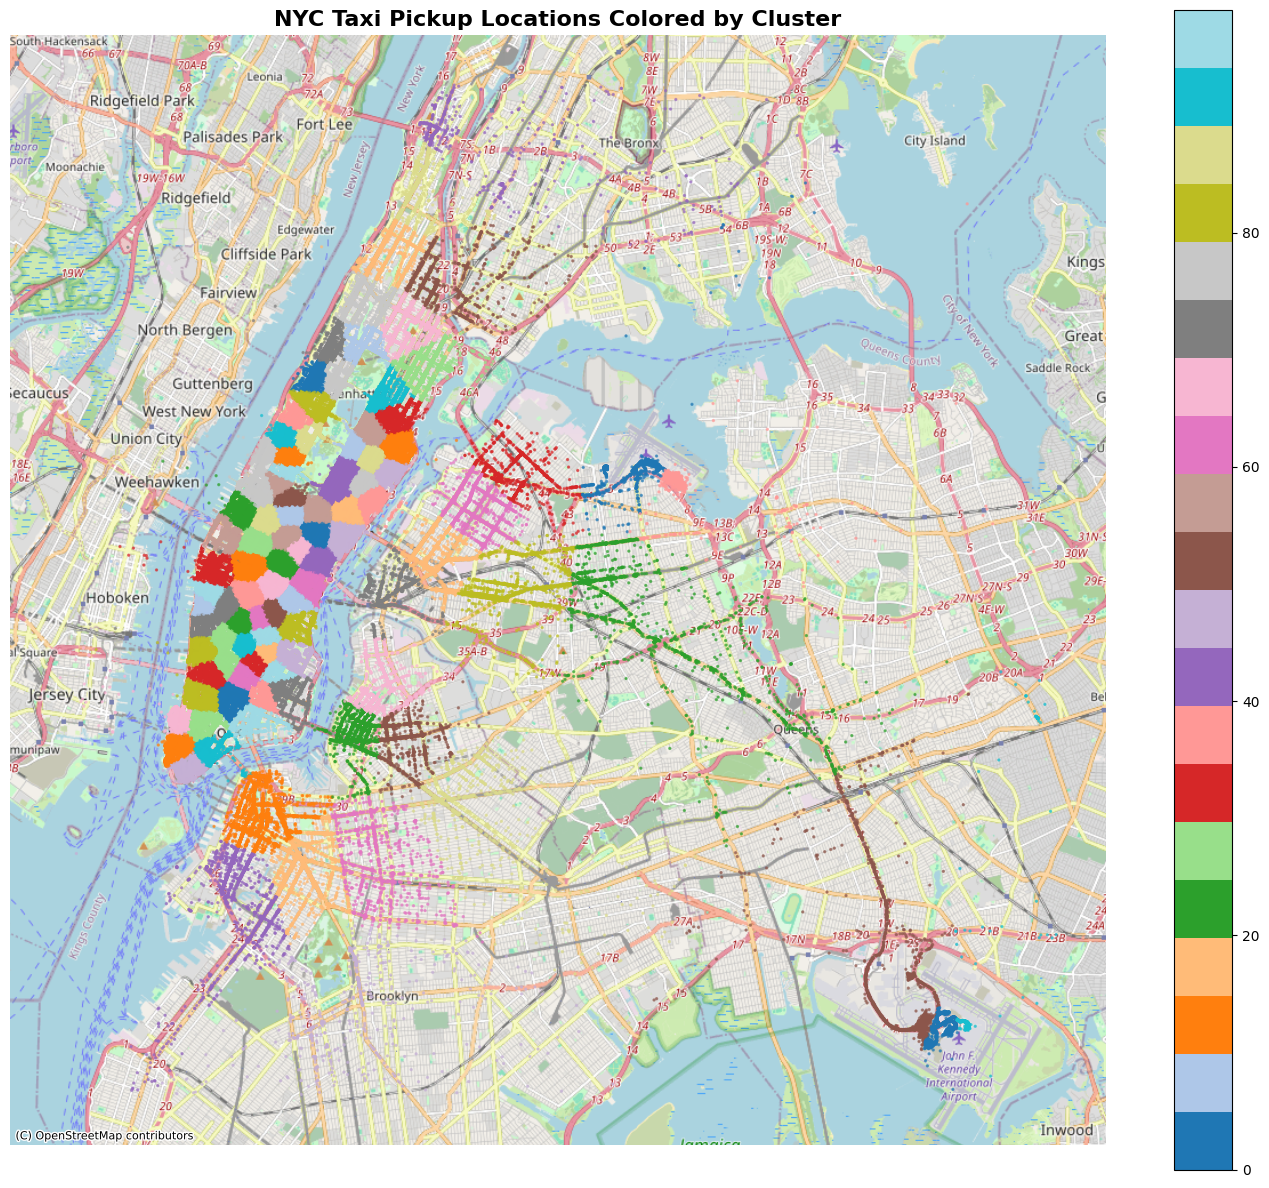

In [33]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import pandas as pd

# Load data
data = pd.read_parquet(output_file)

# For performance, sample 1000k points
sample = data.sample(n=min(1000000, len(data)), random_state=42)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    sample, 
    geometry=gpd.points_from_xy(sample['pickup_longitude'], sample['pickup_latitude']),
    crs="EPSG:4326"
)

# Project to Web Mercator for contextily compatibility
gdf = gdf.to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(14, 12))
scatter = gdf.plot(
    ax=ax,
    column='kmeans_cluster',
    markersize=2,
    cmap='tab20',
    legend=True,
    alpha=0.6
)

# Use OpenStreetMap instead of deprecated Stamen
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.title("NYC Taxi Pickup Locations Colored by Cluster", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

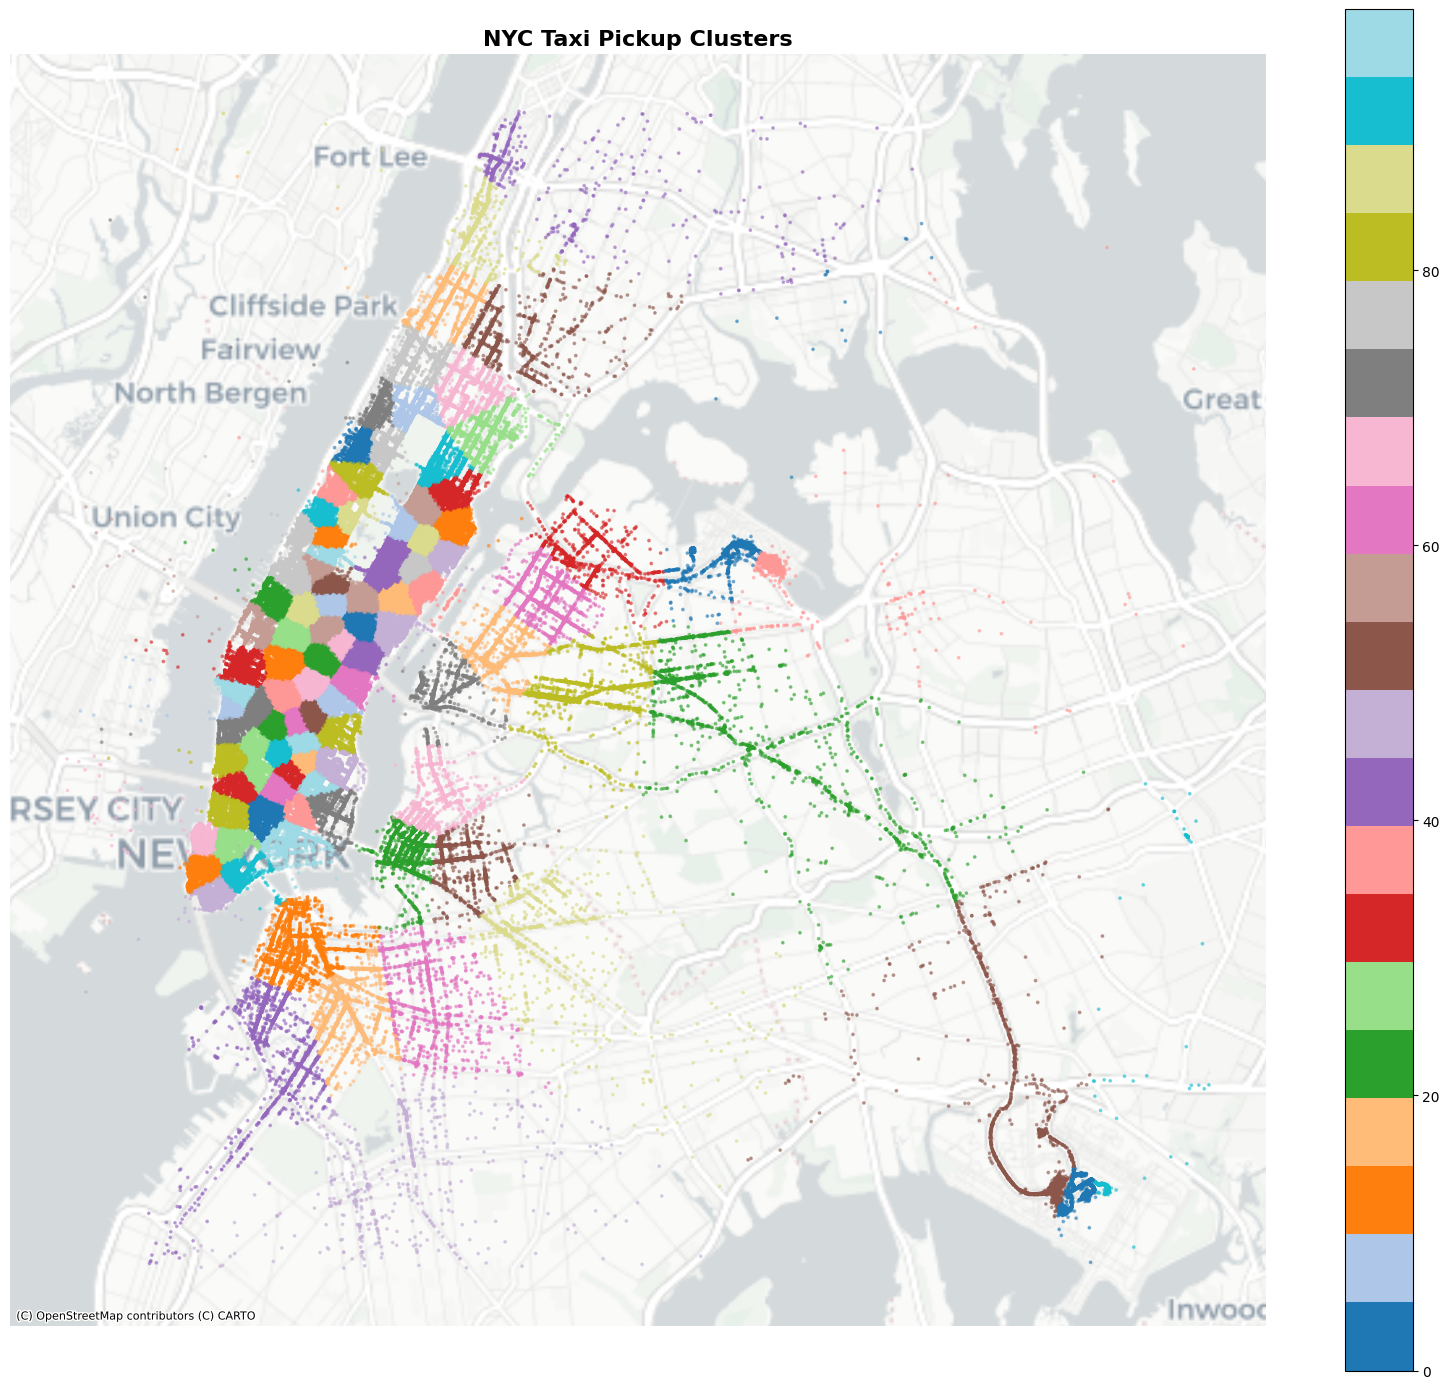

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import pandas as pd

data = pd.read_parquet(output_file)
sample = data.sample(n=min(1_000_000, len(data)), random_state=42)
sample = sample[sample['kmeans_cluster'] != -1]

gdf = gpd.GeoDataFrame(
    sample,
    geometry=gpd.points_from_xy(sample['pickup_longitude'], sample['pickup_latitude']),
    crs="EPSG:4326"
).to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(16, 14))

gdf.plot(ax=ax, column='kmeans_cluster', markersize=3, cmap='tab20', legend=True, alpha=0.5)

# CartoDB Positron - light, clean background perfect for clusters
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=11)

ax.set_axis_off()
plt.title("NYC Taxi Pickup Clusters", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [37]:
import folium
import pandas as pd
import numpy as np

# Load data
output_file = os.path.join(output_path, 'taxi_data_with_clusters_full.parquet')
data = pd.read_parquet(output_file)
sample = data.sample(n=min(20_000, len(data)), random_state=42)

# Setup base map (NYC center)
nyc_map = folium.Map(location=[40.7589, -73.9851], zoom_start=11, tiles='cartodbpositron')

# Select colormap (up to 20 clusters for best result)
cluster_ids = sample['kmeans_cluster'].unique()
colormap = plt.get_cmap('tab20')

for idx, row in sample.iterrows():
    cluster = int(row['kmeans_cluster'])
    color_idx = cluster % 20
    color = np.array(colormap(color_idx)[:3]) * 255
    color_html = f'rgb({int(color[0])},{int(color[1])},{int(color[2])})'
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=1,
        color=color_html,
        fill=True,
        fill_color=color_html,
        fill_opacity=0.5,
        popup=f"Cluster: {cluster}"
    ).add_to(nyc_map)

# Save or display map
nyc_map.save('nyc_taxi_clusters_map_small.html')
print("Map saved as nyc_taxi_clusters_map_small.html")

Map saved as nyc_taxi_clusters_map_small.html
